In [8]:
import os
import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import random
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

In [9]:
# ==================================================
# Data Augmentation Offline para Imágenes NOK
# ==================================================
def save_augmented_images_and_masks(image, mask, folder, base_name, augment_index):
    """
    Guarda imágenes y máscaras aumentadas en el directorio correspondiente.
    """
    augmented_image_name = f"{base_name}_aug_{augment_index}.jpg"
    augmented_mask_name = f"{base_name}_aug_{augment_index}_label.bmp"

    image.save(os.path.join(folder, augmented_image_name))
    
    mask.save(os.path.join(folder, augmented_mask_name))


def augment_nok_images(root_dir, num_augmentations=3):
    """
    Realiza data augmentation exclusivamente para imágenes `NOK` y guarda las nuevas imágenes y máscaras.
    """
    augmentation_transforms = [
        transforms.RandomHorizontalFlip(p=1),  
        transforms.RandomVerticalFlip(p=1),  
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  
    ]

    for folder in sorted(os.listdir(root_dir)):
        folder_path = os.path.join(root_dir, folder)
        if not os.path.isdir(folder_path):
            continue

        images = sorted([f for f in os.listdir(folder_path) if f.endswith(".jpg")])
        masks = sorted([f for f in os.listdir(folder_path) if f.endswith("_label.bmp")])

        for img_name, mask_name in zip(images, masks):
            img_path = os.path.join(folder_path, img_name)
            mask_path = os.path.join(folder_path, mask_name)

            image = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")

            mask_tensor = torch.tensor(list(mask.getdata())).reshape(mask.size)
            if mask_tensor.max() > 0:  # Es una imagen `NOK`
                for i in range(num_augmentations):
                    transform = random.choice(augmentation_transforms)  
                    augmented_image = transform(image)  
                    augmented_mask = transform(mask)   

                    base_name = os.path.splitext(img_name)[0]
                    save_augmented_images_and_masks(augmented_image, augmented_mask, folder_path, base_name, i)

    print("Data augmentation para imágenes NOK completado y guardado en las carpetas correspondientes.")


# ==================================================
# Dataset Personalizado
# ==================================================
class DefectDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment_NOK=False):
        self.root_dir = root_dir
        self.transform = transform
        self.augment_NOK = augment_NOK
        self.data = []
        self._load_data()
    
    def _load_data(self):
        for folder in sorted(os.listdir(self.root_dir)):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            
            images = sorted(glob.glob(os.path.join(folder_path, "Part*.jpg")))
            masks = sorted(glob.glob(os.path.join(folder_path, "Part*_label.bmp")))
            
            for img_path, mask_path in zip(images, masks):
                mask = Image.open(mask_path).convert("L")
                mask_array = torch.tensor(list(mask.getdata())).reshape(mask.size)
                label = 1 if mask_array.max() > 0 else 0
                self.data.append((img_path, label))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


# ==================================================
# Configuración de Transformaciones y Dataset
# ==================================================
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

root_dir = "../Imagenes_defectos"

dataset = DefectDataset(root_dir=root_dir, transform=transform)

# Obtener rutas y etiquetas
image_paths = [item[0] for item in dataset.data]
labels = [item[1] for item in dataset.data]

# ==================================================
# Dividir el Dataset Estratificadamente
# ==================================================
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

def create_subset(dataset, paths):
    indices = [i for i, (path, _) in enumerate(dataset.data) if path in paths]
    return Subset(dataset, indices)

train_dataset = create_subset(dataset, train_paths)
val_dataset = create_subset(dataset, val_paths)
test_dataset = create_subset(dataset, test_paths)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# ==================================================
# Entrenamiento y Validación
# ==================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),  
    nn.Sigmoid()  
)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Entrenando"):
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Pérdida de entrenamiento: {train_loss:.4f}")
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    val_loss /= len(val_loader)
    accuracy = 100 * correct / total
    print(f"Pérdida de validación: {val_loss:.4f}, Precisión: {accuracy:.2f}%")


train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


# ==================================================
# Evaluación
# ==================================================

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    accuracy = 100 * correct / total
    #f1 = f1_score(labels, predictions, average='macro')
    print(f"Precisión en el conjunto de prueba: {accuracy:.2f}%")

test_model(model, test_loader)

C:\Users\joane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\joane\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s]


Epoch 1/10, Pérdida de entrenamiento: 0.3210
Pérdida de validación: 0.1521, Precisión: 95.00%


Epoch 2/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.50it/s]


Epoch 2/10, Pérdida de entrenamiento: 0.1228
Pérdida de validación: 0.1470, Precisión: 93.33%


Epoch 3/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.53it/s]


Epoch 3/10, Pérdida de entrenamiento: 0.0597
Pérdida de validación: 0.1748, Precisión: 95.00%


Epoch 4/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]


Epoch 4/10, Pérdida de entrenamiento: 0.0501
Pérdida de validación: 0.2463, Precisión: 90.00%


Epoch 5/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.54it/s]


Epoch 5/10, Pérdida de entrenamiento: 0.0318
Pérdida de validación: 0.2840, Precisión: 95.00%


Epoch 6/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


Epoch 6/10, Pérdida de entrenamiento: 0.0374
Pérdida de validación: 0.1047, Precisión: 95.00%


Epoch 7/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.46it/s]


Epoch 7/10, Pérdida de entrenamiento: 0.0316
Pérdida de validación: 0.3304, Precisión: 95.00%


Epoch 8/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.52it/s]


Epoch 8/10, Pérdida de entrenamiento: 0.0111
Pérdida de validación: 0.1251, Precisión: 95.00%


Epoch 9/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.40it/s]


Epoch 9/10, Pérdida de entrenamiento: 0.0072
Pérdida de validación: 0.1579, Precisión: 96.67%


Epoch 10/10 - Entrenando: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s]


Epoch 10/10, Pérdida de entrenamiento: 0.0180
Pérdida de validación: 0.2114, Precisión: 93.33%
Precisión en el conjunto de prueba: 96.67%


In [10]:
len(image_paths)


399

In [11]:

def show_predictions(model, loader, num_images=10):
    """
    Muestra imágenes junto con su etiqueta real y la predicción del modelo.
    """
    model.eval()  
    images_shown = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)
            predictions = (outputs > 0.5).float()  

            for i in range(images.size(0)):
                if images_shown >= num_images:
                    return  
                
                img = images[i].cpu().permute(1, 2, 0)  
                label = int(labels[i].item())  
                prediction = int(predictions[i].item())  
                
                img = img * 0.5 + 0.5  
                
                plt.figure(figsize=(4, 4))
                plt.imshow(img.numpy())
                plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
                plt.axis('off')
                plt.show()

                images_shown += 1


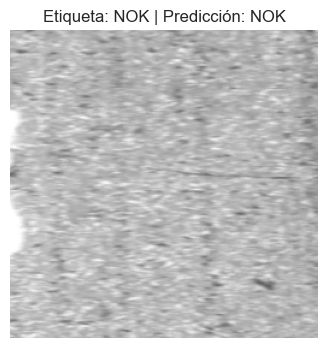

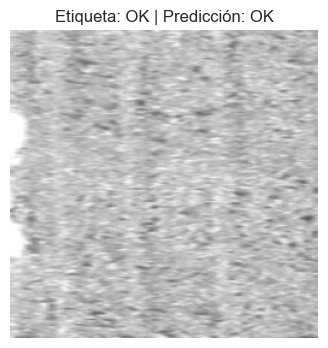

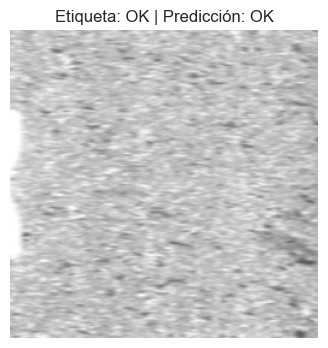

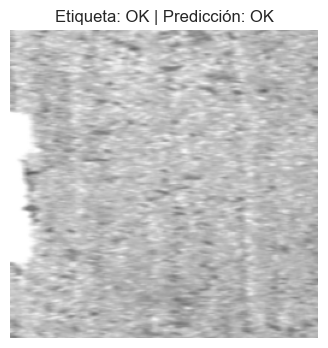

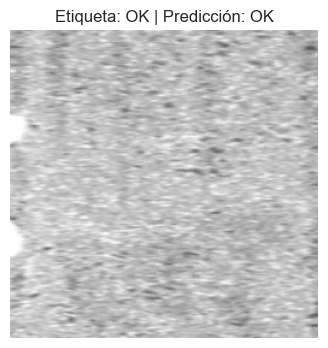

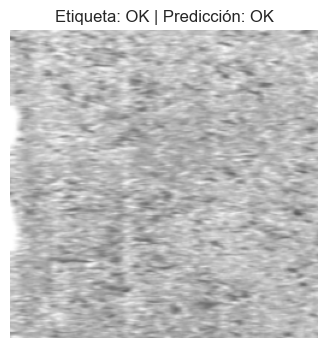

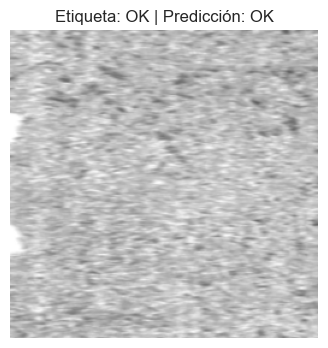

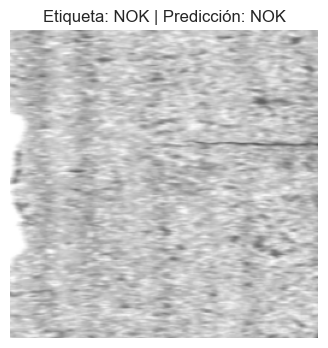

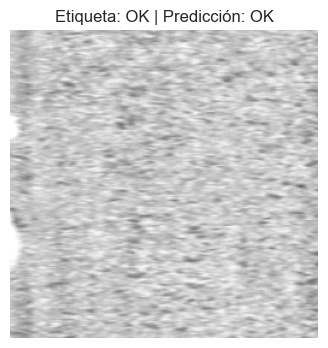

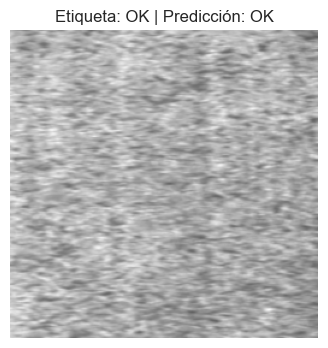

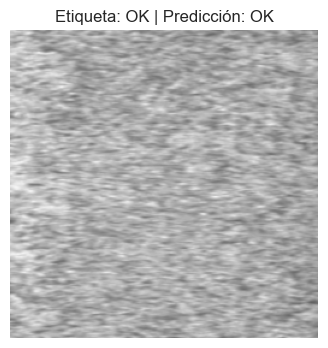

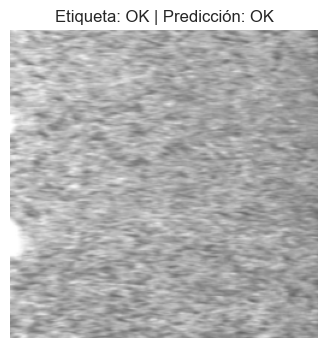

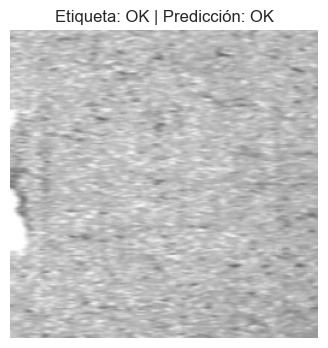

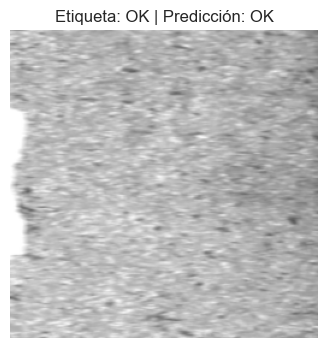

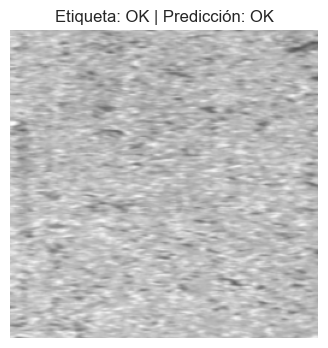

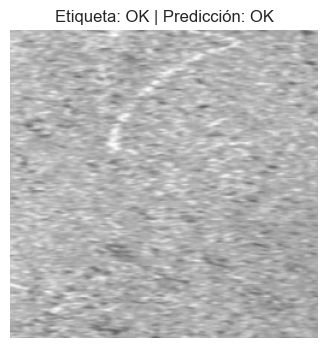

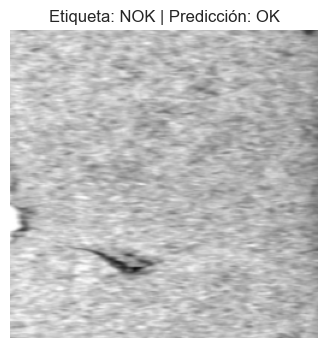

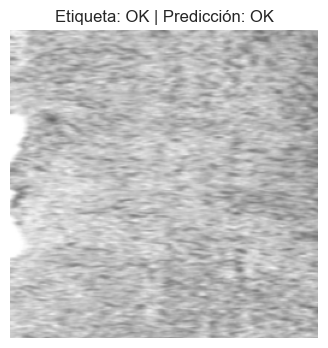

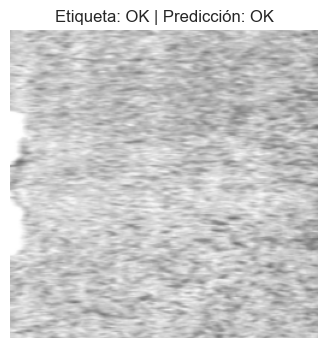

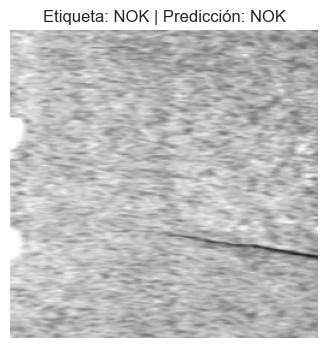

In [12]:
show_predictions(model, test_loader, num_images=20)

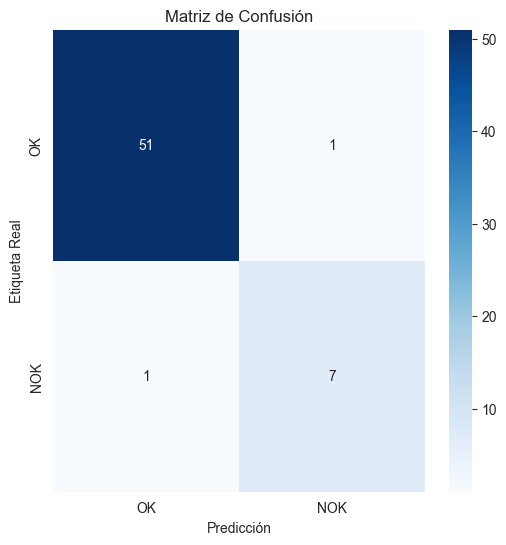

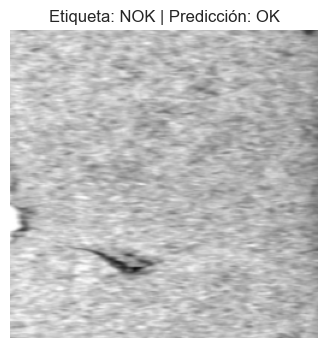

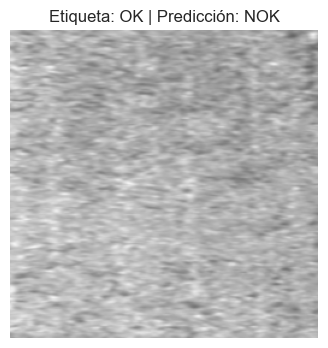

In [17]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

def evaluate_with_confusion_matrix(model, test_loader):
    """
    Evalúa el modelo y genera una matriz de confusión.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])  
    plot_confusion_matrix(cm, classes=['OK', 'NOK'])


def plot_confusion_matrix(cm, classes):
    """
    Muestra una matriz de confusión como un gráfico.
    """
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicción')
    plt.ylabel('Etiqueta Real')
    plt.title('Matriz de Confusión')
    plt.show()

evaluate_with_confusion_matrix(model, test_loader)

def calculate_f1_score(model, test_loader):
    """
    Calcula el F1-score, precisión y recall del modelo usando el conjunto de prueba.
    """
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())

    cm = confusion_matrix(all_labels, all_predictions, labels=[0, 1])
    print("Matriz de Confusión:")
    print(cm)

    report = classification_report(all_labels, all_predictions, target_names=["OK", "NOK"])
    print("\nReporte de Clasificación:")
    print(report)

def find_and_analyze_misclassified(model, test_loader, num_visualizations=10):
    """
    Encuentra las imágenes mal clasificadas, las visualiza y analiza posibles razones.
    """
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()

            for i in range(labels.size(0)):
                if predictions[i].item() != labels[i].item():
                    misclassified.append((images[i], labels[i].item(), predictions[i].item()))

    visualize_misclassified(misclassified, num_visualizations)


def visualize_misclassified(misclassified, num_visualizations):
    """
    Visualiza imágenes mal clasificadas con etiquetas reales y predicciones.
    """
    for i, (image, label, prediction) in enumerate(misclassified[:num_visualizations]):
        image = image.cpu().permute(1, 2, 0)  # Convertir a formato HWC para matplotlib
        image = image * 0.5 + 0.5  # Revertir la normalización (mean=0.5, std=0.5)

        plt.figure(figsize=(4, 4))
        plt.imshow(image.numpy())
        plt.title(f"Etiqueta: {'OK' if label == 0 else 'NOK'} | Predicción: {'OK' if prediction == 0 else 'NOK'}")
        plt.axis('off')
        plt.show()

find_and_analyze_misclassified(model, test_loader, num_visualizations=10)

In [15]:
calculate_f1_score(model, test_loader)

Matriz de Confusión:
[[51  1]
 [ 1  7]]

Reporte de Clasificación:
              precision    recall  f1-score   support

          OK       0.98      0.98      0.98        52
         NOK       0.88      0.88      0.88         8

    accuracy                           0.97        60
   macro avg       0.93      0.93      0.93        60
weighted avg       0.97      0.97      0.97        60



In [16]:
import pickle

# save
with open('model_resnet_aumentado.pkl','wb') as f:
    pickle.dump(model,f)